In [3]:
import pycaret
import pandas as pd

In [4]:
# อ่านไฟล์ CSV
data = pd.read_csv('../../export_data_jsp01/clean_data_jsps001_1d.csv')

In [5]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [6]:
data.tail(5)

,humidity,pm_2_5,temperature
timestamp,,,
2025-02-07 07:00:00,72.053758,27.864365,28.186164
2025-02-08 07:00:00,72.759274,33.923883,28.104894
2025-02-09 07:00:00,69.850659,32.647832,28.231867
2025-02-10 07:00:00,69.598712,32.856690,28.338313
2025-02-11 07:00:00,71.713989,34.038326,28.029813


In [7]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


humidity       75.436933
pm_2_5         41.697658
temperature    30.098761
Name: 2023-09-30 07:00:00, dtype: float64

In [8]:
data = data[['temperature']]

In [9]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [10]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [11]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [12]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [13]:
# data["temp_diff"] = data["temperature"].diff()

In [14]:
data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [15]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

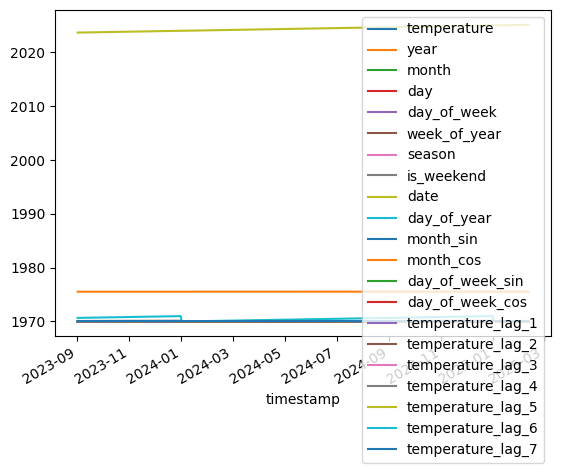

In [16]:
data_filtered.plot()

In [17]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [18]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [19]:
train_data.shape

(500, 21)

In [20]:
test_data.shape

(30, 21)

In [21]:
test_data.head(1)

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,...,month_cos,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,24.857799,2025,1,13,0,3,2,0,2025-01-13,13,...,0.866025,0.0,1.0,26.640566,28.05223,28.380074,28.482274,28.022162,27.094928,25.455684


In [22]:
test_data.tail(1)

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,...,month_cos,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,28.029813,2025,2,11,1,7,0,0,2025-02-11,42,...,0.5,0.781831,0.62349,28.338313,28.231867,28.104894,28.186164,28.15022,27.676822,27.531455


In [23]:
test_data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [24]:
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='temperature', session_id=123, fold=12, remove_outliers = True)

,Description,Value
0,Session id,123
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(500, 21)"
4,Transformed data shape,"(482, 23)"
5,Transformed train set shape,"(332, 23)"
6,Transformed test set shape,"(150, 23)"
7,Numeric features,19
8,Date features,1
9,Preprocess,True


In [25]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.7388,0.9259,0.9455,0.6636,0.0321,0.0259,0.0217
ridge,Ridge Regression,0.7472,0.9377,0.9529,0.6561,0.0324,0.0262,0.0233
omp,Orthogonal Matching Pursuit,0.7526,0.9460,0.9593,0.6543,0.0325,0.0263,0.0208
lr,Linear Regression,0.7529,0.9468,0.9580,0.6520,0.0325,0.0264,0.3150
huber,Huber Regressor,0.7364,0.9581,0.9602,0.6501,0.0326,0.0258,0.0225
rf,Random Forest Regressor,0.7784,1.0097,0.9903,0.6275,0.0336,0.0273,0.0600
et,Extra Trees Regressor,0.8053,1.0780,1.0238,0.6080,0.0347,0.0283,0.0450
ada,AdaBoost Regressor,0.8378,1.0796,1.0274,0.6029,0.0347,0.0293,0.0333
lightgbm,Light Gradient Boosting Machine,0.8035,1.0816,1.0286,0.5971,0.0349,0.0282,0.0783
gbr,Gradient Boosting Regressor,0.8119,1.1180,1.0432,0.5899,0.0353,0.0285,0.0383


In [26]:
model_5 = exp1.create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9152,1.2376,1.1125,0.4697,0.0373,0.0319
1,0.9611,1.6605,1.2886,0.3643,0.0439,0.0341
2,1.0499,1.7196,1.3113,0.4057,0.0453,0.0373
3,1.0205,2.0385,1.4278,0.5389,0.0484,0.0353
4,1.3131,2.8097,1.6762,0.0973,0.0566,0.0453
5,0.9786,1.4717,1.2131,0.4364,0.0408,0.0339
6,1.0854,1.9615,1.4005,0.4529,0.0479,0.0383
7,1.3067,2.5919,1.6099,-0.0638,0.0546,0.0467
8,1.1921,2.7257,1.6510,-0.0276,0.0552,0.0424


In [27]:
# exp1.evaluate_model(model_1)

In [28]:
predictions = exp1.predict_model(model_5, data=test_data)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.2151,2.5408,1.5940,-1.1025,0.0564,0.0454


,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,month_sin,...,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7,temperature,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,2025,1,13,0,3,2,0,2025-01-13,13,0.5,...,1.000000,26.640566,28.052229,28.380074,28.482275,28.022163,27.094929,25.455685,24.857798,27.769157
2025-01-14 07:00:00,2025,1,14,1,3,2,0,2025-01-14,14,0.5,...,0.623490,24.857798,26.640566,28.052229,28.380074,28.482275,28.022163,27.094929,26.152363,28.885925
2025-01-15 07:00:00,2025,1,15,2,3,2,0,2025-01-15,15,0.5,...,-0.222521,26.152363,24.857798,26.640566,28.052229,28.380074,28.482275,28.022163,25.855082,24.833202
2025-01-16 07:00:00,2025,1,16,3,3,2,0,2025-01-16,16,0.5,...,-0.900969,25.855082,26.152363,24.857798,26.640566,28.052229,28.380074,28.482275,27.095964,28.885925
2025-01-17 07:00:00,2025,1,17,4,3,2,0,2025-01-17,17,0.5,...,-0.900969,27.095964,25.855082,26.152363,24.857798,26.640566,28.052229,28.380074,25.693401,29.128929


In [29]:
predict_v = predictions['prediction_label']
real = test_data['temperature']

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

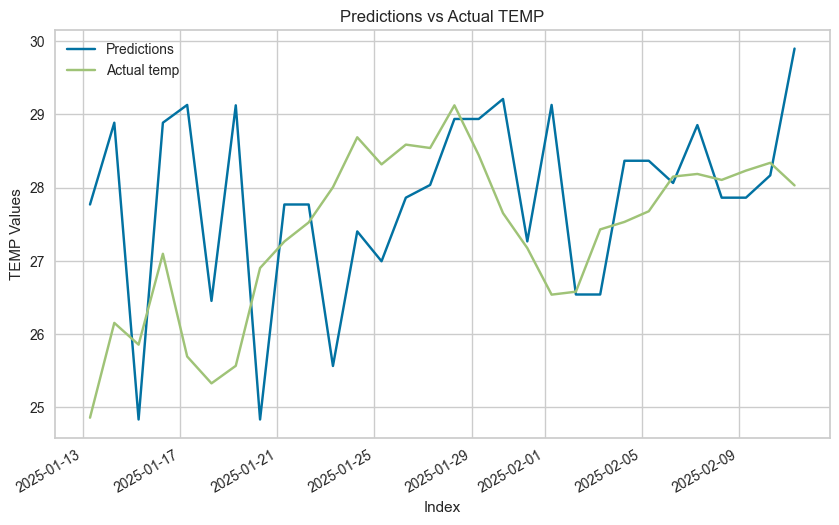

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['temperature']], axis=1)
result.columns = ['Predictions', 'Actual temp']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual TEMP')
plt.xlabel('Index')
plt.ylabel('TEMP Values')

# แสดงกราฟ
plt.show()

In [31]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["temperature"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -0.8138
Mean Absolute Error (MAE): 1.0731
Root Mean Squared Error (RMSE): 1.4969
Mean Absolute Percentage Error (MAPE): 4.02%
Accuracy: 95.98%


In [32]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["temperature"][:7]
y_pred = (predict_v.shift(-1).dropna(axis=0))[:7]

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -14.6880
Mean Absolute Error (MAE): 2.2429
Root Mean Squared Error (RMSE): 2.5861
Mean Absolute Percentage Error (MAPE): 8.76%
Accuracy: 91.24%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [33]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

In [34]:
model_5 = exp1.create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9152,1.2376,1.1125,0.4697,0.0373,0.0319
1,0.9611,1.6605,1.2886,0.3643,0.0439,0.0341
2,1.0499,1.7196,1.3113,0.4057,0.0453,0.0373
3,1.0205,2.0385,1.4278,0.5389,0.0484,0.0353
4,1.3131,2.8097,1.6762,0.0973,0.0566,0.0453
5,0.9786,1.4717,1.2131,0.4364,0.0408,0.0339
6,1.0854,1.9615,1.4005,0.4529,0.0479,0.0383
7,1.3067,2.5919,1.6099,-0.0638,0.0546,0.0467
8,1.1921,2.7257,1.6510,-0.0276,0.0552,0.0424


In [ ]:
exp1.evaluate_model(model_5)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [36]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_5

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

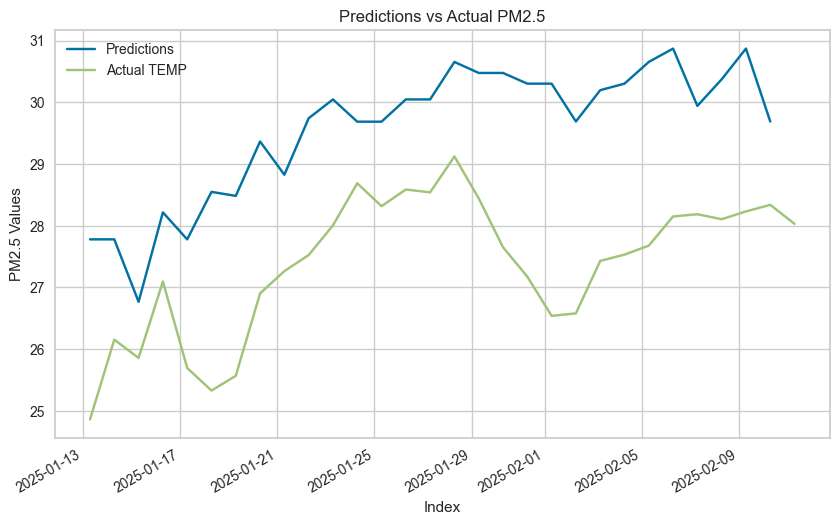

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [38]:
# exp1.save_model(model_5, "dt_jsps01_temp_model")

In [39]:
y_true = test_data["temperature"][:"2025-2-10"]
y_pred = result["prediction_label"].shift(-1).dropna(axis=0)

In [40]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -3.4148
Mean Absolute Error (MAE): 2.2097
Root Mean Squared Error (RMSE): 2.3353
Mean Absolute Percentage Error (MAPE): 8.13%
Accuracy: 91.87%


In [41]:
y_true = test_data["temperature"][:7]
y_pred = (result["prediction_label"].shift(-1).dropna(axis=0))[:7]

I THINK THAT COMPLETE FOR TEMP  
THE MODEL IS 'rf'
Accuracy(MAPE) = 100 - 2.45 = 96.61 %

Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6137,6.8314,2.6137,nan,0.0963,0.1051


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.9490,3.7985,1.9490,nan,0.0693,0.0745


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6563,7.0561,2.6563,nan,0.0943,0.1027


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.8324,3.3575,1.8324,nan,0.0632,0.0676


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.3531,11.2430,3.3531,nan,0.1183,0.1305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.6977,13.6729,3.6977,nan,0.1314,0.1460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.3837,11.4491,3.3837,nan,0.1199,0.1323


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.0350,4.1411,2.0350,nan,0.0704,0.0756


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.8184,3.3066,1.8184,nan,0.0624,0.0667


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.8025,3.2490,1.8025,nan,0.0613,0.0655


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.5199,2.3102,1.5199,nan,0.0511,0.0543


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8759,0.7672,0.8759,nan,0.0291,0.0305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.2330,1.5204,1.2330,nan,0.0412,0.0435


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8417,0.7084,0.8417,nan,0.0280,0.0294


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8066,0.6505,0.8066,nan,0.0269,0.0283


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3124,0.0976,0.3124,nan,0.0103,0.0107


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.1832,1.3999,1.1832,nan,0.0394,0.0416


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.1309,4.5407,2.1309,nan,0.0717,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6166,6.8464,2.6166,nan,0.0888,0.0963


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.4448,11.8669,3.4448,nan,0.1179,0.1298


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.3903,11.4939,3.3903,nan,0.1159,0.1276


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.5141,6.3207,2.5141,nan,0.0847,0.0917


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.5487,6.4960,2.5487,nan,0.0856,0.0926


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6200,6.8645,2.6200,nan,0.0874,0.0947


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3216,5.3899,2.3216,nan,0.0766,0.0825


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3211,5.3874,2.3211,nan,0.0765,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3917,5.7202,2.3917,nan,0.0790,0.0851


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.1431,4.5930,2.1431,nan,0.0708,0.0759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.9549,3.8217,1.9549,nan,0.0645,0.0690


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3497,5.5209,2.3497,nan,0.0778,0.0838


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.5063,6.2815,2.5063,nan,0.0925,0.1008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.8705,3.4987,1.8705,nan,0.0666,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.6432,6.9867,2.6432,nan,0.0939,0.1022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.8440,3.4005,1.8440,nan,0.0636,0.0681


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.2128,10.3221,3.2128,nan,0.1136,0.1250


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.7385,13.9761,3.7385,nan,0.1328,0.1476


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.2920,10.8375,3.2920,nan,0.1168,0.1288


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.8866,3.5592,1.8866,nan,0.0654,0.0701


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.6913,2.8604,1.6913,nan,0.0581,0.0620


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.7378,3.0198,1.7378,nan,0.0591,0.0631


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.4730,2.1697,1.4730,nan,0.0495,0.0526


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6715,0.4509,0.6715,nan,0.0224,0.0234


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.2039,1.4494,1.2039,nan,0.0402,0.0425


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6598,0.4353,0.6598,nan,0.0221,0.0231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5696,0.3244,0.5696,nan,0.0191,0.0200


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1063,0.0113,0.1063,nan,0.0035,0.0036


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.0453,1.0926,1.0453,nan,0.0349,0.0367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.0184,4.0739,2.0184,nan,0.0681,0.0730


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.3529,5.5363,2.3529,nan,0.0802,0.0866


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.4144,11.6584,3.4144,nan,0.1169,0.1287


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.2553,10.5968,3.2553,nan,0.1116,0.1225


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.3511,5.5276,2.3511,nan,0.0795,0.0857


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.4403,5.9552,2.4403,nan,0.0821,0.0886


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.5960,6.7392,2.5960,nan,0.0867,0.0938


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.3334,5.4449,2.3334,nan,0.0770,0.0829


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.1930,4.8094,2.1930,nan,0.0725,0.0778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.4486,5.9956,2.4486,nan,0.0808,0.0871


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.0549,4.2227,2.0549,nan,0.0679,0.0728


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.8196,3.3110,1.8196,nan,0.0602,0.0642


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.2517,5.0703,2.2517,nan,0.0747,0.0803


Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.9739,8.8442,2.9739,nan,0.1089,0.1196


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.5255,6.3780,2.5255,nan,0.0889,0.0966


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4229,11.7165,3.4229,nan,0.1200,0.1324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.6070,6.7963,2.6070,nan,0.0887,0.0962


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.3095,18.5719,4.3095,nan,0.1497,0.1677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.8871,23.8840,4.8871,nan,0.1703,0.1930


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.7952,22.9941,4.7952,nan,0.1659,0.1876


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.5618,12.6862,3.5618,nan,0.1201,0.1324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.2700,10.6930,3.2700,nan,0.1095,0.1199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.0566,9.3427,3.0566,nan,0.1018,0.1111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.6061,6.7919,2.6061,nan,0.0860,0.0931


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.9432,3.7759,1.9432,nan,0.0634,0.0677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.3238,5.3998,2.3238,nan,0.0763,0.0821


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.0588,4.2385,2.0588,nan,0.0673,0.0720


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.1054,4.4327,2.1054,nan,0.0688,0.0738


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.5203,2.3112,1.5203,nan,0.0492,0.0522


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.1957,4.8209,2.1957,nan,0.0719,0.0772


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.9816,8.8897,2.9816,nan,0.0990,0.1078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4515,11.9126,3.4515,nan,0.1156,0.1270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.0792,16.6402,4.0792,nan,0.1381,0.1537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.0306,16.2455,4.0306,nan,0.1364,0.1516


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.1711,10.0556,3.1711,nan,0.1058,0.1156


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.0591,9.3580,3.0591,nan,0.1019,0.1111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.9042,8.4345,2.9042,nan,0.0965,0.1049


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.4212,5.8622,2.4212,nan,0.0798,0.0860


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.3755,5.6431,2.3755,nan,0.0782,0.0843


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.4470,5.9878,2.4470,nan,0.0807,0.0871


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.3102,5.3368,2.3102,nan,0.0761,0.0818


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.1938,4.8128,2.1938,nan,0.0721,0.0774


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.4924,6.2121,2.4924,nan,0.0824,0.0889


Processing model: LinearRegression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.4988,6.2440,2.4988,nan,0.0922,0.1005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.8634,3.4723,1.8634,nan,0.0664,0.0713


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.6464,7.0035,2.6464,nan,0.0940,0.1024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.8481,3.4154,1.8481,nan,0.0637,0.0682


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.1884,10.1657,3.1884,nan,0.1128,0.1241


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.7499,14.0621,3.7499,nan,0.1332,0.1481


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.2824,10.7742,3.2824,nan,0.1165,0.1284


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.8694,3.4948,1.8694,nan,0.0649,0.0695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.6780,2.8158,1.6780,nan,0.0577,0.0615


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.7337,3.0056,1.7337,nan,0.0590,0.0630


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.4705,2.1624,1.4705,nan,0.0495,0.0525


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.6418,0.4120,0.6418,nan,0.0214,0.0224


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.2098,1.4635,1.2098,nan,0.0404,0.0427


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.6423,0.4126,0.6423,nan,0.0215,0.0225


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.5446,0.2966,0.5446,nan,0.0183,0.0191


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0859,0.0074,0.0859,nan,0.0028,0.0029


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.0346,1.0705,1.0346,nan,0.0345,0.0364


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.0102,4.0409,2.0102,nan,0.0678,0.0727


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.3183,5.3744,2.3183,nan,0.0791,0.0853


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.4186,11.6868,3.4186,nan,0.1170,0.1288


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.2391,10.4917,3.2391,nan,0.1110,0.1219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.3289,5.4237,2.3289,nan,0.0787,0.0849


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.4240,5.8756,2.4240,nan,0.0815,0.0880


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.5904,6.7101,2.5904,nan,0.0865,0.0936


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.3309,5.4330,2.3309,nan,0.0769,0.0828


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.1647,4.6861,2.1647,nan,0.0715,0.0768


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.4564,6.0337,2.4564,nan,0.0810,0.0874


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.0398,4.1607,2.0398,nan,0.0675,0.0723


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.7973,3.2302,1.7973,nan,0.0595,0.0634


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.2343,4.9921,2.2343,nan,0.0741,0.0797


Processing model: HuberRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.4616,6.0594,2.4616,nan,0.0909,0.0990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.4772,2.1822,1.4772,nan,0.0530,0.0565


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.1579,4.6565,2.1579,nan,0.0773,0.0835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.3242,1.7535,1.3242,nan,0.0461,0.0489


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.9826,8.8960,2.9826,nan,0.1059,0.1161


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.4082,11.6156,3.4082,nan,0.1217,0.1346


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.1535,9.9445,3.1535,nan,0.1122,0.1233


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.8675,3.4875,1.8675,nan,0.0648,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.6268,2.6465,1.6268,nan,0.0560,0.0597


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.5648,2.4486,1.5648,nan,0.0534,0.0569


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.2924,1.6703,1.2924,nan,0.0436,0.0461


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.7480,0.5595,0.7480,nan,0.0249,0.0261


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.1443,1.3094,1.1443,nan,0.0383,0.0404


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.8502,0.7229,0.8502,nan,0.0283,0.0297


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9003,0.8105,0.9003,nan,0.0300,0.0315


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.3974,0.1579,0.3974,nan,0.0131,0.0136


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.2289,1.5103,1.2289,nan,0.0409,0.0432


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.1800,4.7523,2.1800,nan,0.0733,0.0788


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.7502,7.5634,2.7502,nan,0.0931,0.1012


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.5630,12.6951,3.5630,nan,0.1217,0.1343


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.5750,12.7804,3.5750,nan,0.1219,0.1345


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.7947,7.8106,2.7947,nan,0.0938,0.1019


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.8292,8.0046,2.8292,nan,0.0945,0.1028


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.8767,8.2756,2.8767,nan,0.0956,0.1039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.5932,6.7246,2.5932,nan,0.0852,0.0921


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.6804,7.1847,2.6804,nan,0.0879,0.0951


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.7834,7.7475,2.7834,nan,0.0913,0.0990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.6297,6.9153,2.6297,nan,0.0861,0.0931


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.5263,6.3820,2.5263,nan,0.0826,0.0891


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.9142,8.4928,2.9142,nan,0.0957,0.1040


Processing model: RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.1334,9.8185,3.1334,nan,0.1144,0.1261


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.8508,3.4254,1.8508,nan,0.0659,0.0708


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.2541,5.0811,2.2541,nan,0.0806,0.0872


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.0346,1.0704,1.0346,nan,0.0362,0.0382


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.0902,4.3691,2.0902,nan,0.0754,0.0814


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.0434,9.2620,3.0434,nan,0.1094,0.1202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.0387,9.2335,3.0387,nan,0.1083,0.1189


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.9504,3.8042,1.9504,nan,0.0676,0.0725


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.6495,2.7208,1.6495,nan,0.0567,0.0605


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.5169,2.3011,1.5169,nan,0.0518,0.0551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.0471,1.0964,1.0471,nan,0.0355,0.0374


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3043,0.0926,0.3043,nan,0.0102,0.0106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6599,0.4354,0.6599,nan,0.0223,0.0233


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4086,0.1670,0.4086,nan,0.0137,0.0143


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4510,0.2034,0.4510,nan,0.0152,0.0158


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0799,0.0064,0.0799,nan,0.0027,0.0027


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6090,0.3709,0.6090,nan,0.0205,0.0214


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.3917,1.9369,1.3917,nan,0.0474,0.0503


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.8793,3.5316,1.8793,nan,0.0646,0.0692


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.4627,6.0651,2.4627,nan,0.0857,0.0928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.4010,5.7646,2.4010,nan,0.0835,0.0903


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.5241,2.3228,1.5241,nan,0.0522,0.0556


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.5447,2.3862,1.5447,nan,0.0527,0.0561


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.3975,1.9530,1.3975,nan,0.0476,0.0505


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9769,0.9543,0.9769,nan,0.0330,0.0347


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9267,0.8589,0.9267,nan,0.0313,0.0329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.0055,1.0109,1.0055,nan,0.0340,0.0358


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.8085,0.6536,0.8085,nan,0.0273,0.0286


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6568,0.4314,0.6568,nan,0.0221,0.0232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.0676,1.1397,1.0676,nan,0.0361,0.0381


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.7039,13.7192,3.7039,nan,0.1339,0.1490


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.7271,7.4372,2.7271,nan,0.0957,0.1043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.2483,10.5518,3.2483,nan,0.1142,0.1256


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.0199,4.0800,2.0199,nan,0.0694,0.0745


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.5220,12.4046,3.5220,nan,0.1239,0.1371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.5384,12.5202,3.5384,nan,0.1261,0.1397


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.5211,12.3982,3.5211,nan,0.1245,0.1377


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.8659,3.4816,1.8659,nan,0.0647,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.8220,3.3197,1.8220,nan,0.0625,0.0668


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4494,2.1009,1.4494,nan,0.0496,0.0527


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1770,1.3853,1.1770,nan,0.0398,0.0420


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3662,0.1341,0.3662,nan,0.0123,0.0128


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6305,0.3975,0.6305,nan,0.0213,0.0223


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4487,0.2013,0.4487,nan,0.0151,0.0157


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1749,0.0306,0.1749,nan,0.0059,0.0061


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0128,0.0002,0.0128,nan,0.0004,0.0004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4536,0.2057,0.4536,nan,0.0153,0.0159


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4374,2.0661,1.4374,nan,0.0490,0.0520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.7353,3.0112,1.7353,nan,0.0598,0.0639


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.4935,6.2176,2.4935,nan,0.0867,0.0940


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.4224,5.8682,2.4224,nan,0.0842,0.0911


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4860,2.2081,1.4860,nan,0.0509,0.0542


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.5900,2.5281,1.5900,nan,0.0542,0.0578


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4196,2.0152,1.4196,nan,0.0483,0.0513


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.0340,1.0691,1.0340,nan,0.0349,0.0367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.0703,1.1456,1.0703,nan,0.0360,0.0380


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.2574,1.5811,1.2574,nan,0.0423,0.0447


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1712,1.3718,1.1712,nan,0.0393,0.0415


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8695,0.7561,0.8695,nan,0.0292,0.0307


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8719,0.7602,0.8719,nan,0.0296,0.0311


Processing model: AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.8430,8.0825,2.8430,nan,0.1043,0.1144


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.7179,2.9510,1.7179,nan,0.0613,0.0657


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.9467,3.7895,1.9467,nan,0.0700,0.0753


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.7529,0.5668,0.7529,nan,0.0264,0.0278


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.0142,4.0570,2.0142,nan,0.0727,0.0784


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.5435,6.4694,2.5435,nan,0.0922,0.1004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.2161,4.9109,2.2161,nan,0.0801,0.0867


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.9018,0.8133,0.9018,nan,0.0318,0.0335


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5759,0.3317,0.5759,nan,0.0202,0.0211


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2796,0.0782,0.2796,nan,0.0098,0.0102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2015,0.0406,0.2015,nan,0.0070,0.0072


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.8834,0.7804,0.8834,nan,0.0302,0.0308


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.4469,0.1997,0.4469,nan,0.0154,0.0158


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.7166,0.5136,0.7166,nan,0.0245,0.0251


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.6705,0.4496,0.6705,nan,0.0230,0.0235


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.2531,1.5703,1.2531,nan,0.0425,0.0430


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5731,0.3284,0.5731,nan,0.0197,0.0201


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2190,0.0480,0.2190,nan,0.0076,0.0079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.6962,0.4847,0.6962,nan,0.0244,0.0256


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.3106,1.7178,1.3106,nan,0.0465,0.0494


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.2235,1.4969,1.2235,nan,0.0434,0.0460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3730,0.1391,0.3730,nan,0.0130,0.0136


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2703,0.0731,0.2703,nan,0.0094,0.0098


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.1249,0.0156,0.1249,nan,0.0043,0.0045


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3485,0.1214,0.3485,nan,0.0120,0.0124


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3844,0.1478,0.3844,nan,0.0133,0.0136


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2561,0.0656,0.2561,nan,0.0088,0.0091


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.4301,0.1850,0.4301,nan,0.0148,0.0152


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5366,0.2879,0.5366,nan,0.0185,0.0189


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2281,0.0520,0.2281,nan,0.0079,0.0081


Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9100,8.4680,2.9100,nan,0.1066,0.1171


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.7311,2.9967,1.7311,nan,0.0618,0.0662


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1565,4.6504,2.1565,nan,0.0772,0.0834


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.5657,2.4515,1.5657,nan,0.0542,0.0578


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.5250,12.4255,3.5250,nan,0.1240,0.1372


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.7469,14.0389,3.7469,nan,0.1331,0.1479


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.3975,11.5429,3.3975,nan,0.1203,0.1329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.4594,6.0487,2.4594,nan,0.0845,0.0914


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.3469,1.8142,1.3469,nan,0.0466,0.0494


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1406,4.5821,2.1406,nan,0.0724,0.0778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.4361,2.0625,1.4361,nan,0.0483,0.0513


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3105,0.0964,0.3105,nan,0.0104,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.0746,1.1547,1.0746,nan,0.0360,0.0379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2649,0.0701,0.2649,nan,0.0090,0.0093


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5540,0.3069,0.5540,nan,0.0186,0.0194


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4912,0.2413,0.4912,nan,0.0164,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5027,0.2527,0.5027,nan,0.0169,0.0177


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.4995,2.2486,1.4995,nan,0.0510,0.0542


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.6511,2.7262,1.6511,nan,0.0570,0.0608


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9761,8.8574,2.9761,nan,0.1026,0.1121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1854,4.7761,2.1854,nan,0.0763,0.0822


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8590,3.4560,1.8590,nan,0.0633,0.0678


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.6712,2.7930,1.6712,nan,0.0569,0.0607


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.4925,2.2276,1.4925,nan,0.0507,0.0539


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.4199,2.0162,1.4199,nan,0.0476,0.0504


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.5402,2.3721,1.5402,nan,0.0514,0.0546


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.6479,2.7157,1.6479,nan,0.0551,0.0586


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1129,1.2386,1.1129,nan,0.0374,0.0394


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2358,0.0556,0.2358,nan,0.0080,0.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0112,0.0001,0.0112,nan,0.0004,0.0004


Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.9442,8.6685,2.9442,nan,0.1078,0.1184


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.0353,4.1423,2.0353,nan,0.0723,0.0778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.3953,5.7376,2.3953,nan,0.0854,0.0926


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.4034,1.9696,1.4034,nan,0.0487,0.0518


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.0572,9.3466,3.0572,nan,0.1084,0.1190


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.5453,12.5694,3.5453,nan,0.1263,0.1400


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.6950,7.2632,2.6950,nan,0.0966,0.1054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.4928,2.2284,1.4928,nan,0.0521,0.0555


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.5935,2.5392,1.5935,nan,0.0548,0.0584


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.1522,1.3275,1.1522,nan,0.0396,0.0419


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.0179,1.0360,1.0179,nan,0.0345,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3748,0.1405,0.3748,nan,0.0125,0.0131


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4423,0.1956,0.4423,nan,0.0150,0.0156


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.5107,0.2608,0.5107,nan,0.0171,0.0179


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2842,0.0808,0.2842,nan,0.0096,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0619,0.0038,0.0619,nan,0.0021,0.0021


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.5930,0.3516,0.5930,nan,0.0199,0.0208


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.4865,2.2097,1.4865,nan,0.0506,0.0538


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.7808,3.1714,1.7808,nan,0.0613,0.0655


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.4230,5.8710,2.4230,nan,0.0843,0.0913


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.3615,5.5765,2.3615,nan,0.0822,0.0888


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.3037,1.6995,1.3037,nan,0.0448,0.0475


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.1431,1.3067,1.1431,nan,0.0393,0.0415


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.2051,1.4523,1.2051,nan,0.0412,0.0435


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8129,0.6608,0.8129,nan,0.0275,0.0289


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.9348,0.8738,0.9348,nan,0.0315,0.0332


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.0161,1.0324,1.0161,nan,0.0343,0.0362


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.6202,0.3846,0.6202,nan,0.0210,0.0220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4492,0.2018,0.4492,nan,0.0152,0.0159


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7834,0.6137,0.7834,nan,0.0266,0.0279


Processing model: KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.7397,13.9854,3.7397,nan,0.1351,0.1504


  File "d:\Normal File\Coder\MINI_PROJECT_1-2\pycaret_venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.8522,8.1348,2.8522,nan,0.0999,0.1091


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.1494,9.9189,3.1494,nan,0.1109,0.1218


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.0236,4.0951,2.0236,nan,0.0696,0.0747


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.4503,11.9046,3.4503,nan,0.1216,0.1343


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.8170,14.5694,3.8170,nan,0.1354,0.1507


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.5039,12.2775,3.5039,nan,0.1239,0.1371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.2079,4.8747,2.2079,nan,0.0762,0.0821


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.7285,2.9877,1.7285,nan,0.0594,0.0634


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.4125,1.9953,1.4125,nan,0.0483,0.0513


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.8069,0.6511,0.8069,nan,0.0274,0.0288


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1250,0.0156,0.1250,nan,0.0042,0.0044


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6484,0.4205,0.6484,nan,0.0219,0.0229


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.3787,0.1434,0.3787,nan,0.0127,0.0132


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.4249,0.1805,0.4249,nan,0.0143,0.0149


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.2435,0.0593,0.2435,nan,0.0081,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.4366,0.1906,0.4366,nan,0.0147,0.0153


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.2287,1.5096,1.2287,nan,0.0420,0.0444


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.7058,2.9099,1.7058,nan,0.0588,0.0628


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.5066,6.2828,2.5066,nan,0.0871,0.0945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.4665,6.0836,2.4665,nan,0.0857,0.0928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.6160,2.6114,1.6160,nan,0.0553,0.0589


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.5133,2.2901,1.5133,nan,0.0517,0.0550


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.3679,1.8712,1.3679,nan,0.0466,0.0494


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.1107,1.2337,1.1107,nan,0.0374,0.0395


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.2080,1.4593,1.2080,nan,0.0406,0.0429


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.2893,1.6622,1.2893,nan,0.0433,0.0459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.8293,0.6877,0.8293,nan,0.0280,0.0294


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.7526,0.5663,0.7526,nan,0.0253,0.0266


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.9207,0.8478,0.9207,nan,0.0312,0.0328


Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.3479,18.9042,4.3479,nan,0.1554,0.1749


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.8964,15.1819,3.8964,nan,0.1341,0.1490


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.5241,20.4671,4.5241,nan,0.1557,0.1750


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.4329,11.7850,3.4329,nan,0.1153,0.1267


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.8962,23.9732,4.8962,nan,0.1684,0.1906


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.2844,27.9250,5.2844,nan,0.1829,0.2086


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.0494,25.4961,5.0494,nan,0.1740,0.1975


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.7105,13.7675,3.7105,nan,0.1249,0.1379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.3421,11.1698,3.3421,nan,0.1118,0.1226


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.0736,9.4472,3.0736,nan,0.1023,0.1117


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.5838,6.6762,2.5838,nan,0.0853,0.0923


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.8929,3.5832,1.8929,nan,0.0618,0.0660


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2538,5.0794,2.2538,nan,0.0741,0.0796


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9749,3.9001,1.9749,nan,0.0646,0.0691


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.0118,4.0475,2.0118,nan,0.0659,0.0705


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.4200,2.0164,1.4200,nan,0.0461,0.0488


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.0909,4.3717,2.0909,nan,0.0686,0.0735


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.8738,8.2585,2.8738,nan,0.0956,0.1039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.3417,11.1671,3.3417,nan,0.1121,0.1230


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.9684,15.7479,3.9684,nan,0.1346,0.1495


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.9191,15.3593,3.9191,nan,0.1329,0.1475


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.0594,9.3599,3.0594,nan,0.1022,0.1115


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.9475,8.6877,2.9475,nan,0.0983,0.1071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.7929,7.8005,2.7929,nan,0.0929,0.1009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.3103,5.3376,2.3103,nan,0.0763,0.0821


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2652,5.1310,2.2652,nan,0.0747,0.0804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.3372,5.4627,2.3372,nan,0.0772,0.0832


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2011,4.8447,2.2011,nan,0.0726,0.0780


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.0854,4.3490,2.0854,nan,0.0687,0.0736


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.3847,5.6869,2.3847,nan,0.0789,0.0851


Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.0029,25.0287,5.0029,nan,0.1769,0.2013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.3322,18.7679,4.3322,nan,0.1480,0.1657


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.7445,22.5102,4.7445,nan,0.1627,0.1835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.5189,12.3827,3.5189,nan,0.1180,0.1299


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.9172,24.1789,4.9172,nan,0.1691,0.1914


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.2758,27.8339,5.2758,nan,0.1827,0.2083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.0275,25.2762,5.0275,nan,0.1733,0.1966


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.6829,13.5635,3.6829,nan,0.1240,0.1369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.3121,10.9699,3.3121,nan,0.1108,0.1215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.0426,9.2574,3.0426,nan,0.1014,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.5525,6.5151,2.5525,nan,0.0843,0.0911


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.8615,3.4653,1.8615,nan,0.0608,0.0649


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.2224,4.9391,2.2224,nan,0.0731,0.0785


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.9437,3.7779,1.9437,nan,0.0636,0.0680


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.9808,3.9235,1.9808,nan,0.0649,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.3891,1.9297,1.3891,nan,0.0451,0.0477


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.0601,4.2442,2.0601,nan,0.0676,0.0724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.8432,8.0839,2.8432,nan,0.0946,0.1028


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.3114,10.9651,3.3114,nan,0.1111,0.1219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.9382,15.5093,3.9382,nan,0.1337,0.1484


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.8891,15.1250,3.8891,nan,0.1319,0.1463


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.0296,9.1783,3.0296,nan,0.1013,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.9178,8.5138,2.9178,nan,0.0974,0.1060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.7635,7.6367,2.7635,nan,0.0920,0.0998


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.2810,5.2031,2.2810,nan,0.0753,0.0810


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.2361,4.9999,2.2361,nan,0.0738,0.0793


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.3083,5.3282,2.3083,nan,0.0763,0.0821


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.1723,4.7189,2.1723,nan,0.0717,0.0769


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.0568,4.2305,2.0568,nan,0.0678,0.0726


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.3563,5.5522,2.3563,nan,0.0780,0.0841


Processing model: LassoLars


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.0029,25.0290,5.0029,nan,0.1769,0.2013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.3322,18.7681,4.3322,nan,0.1480,0.1657


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.7445,22.5104,4.7445,nan,0.1627,0.1835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.5189,12.3828,3.5189,nan,0.1180,0.1299


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.9172,24.1791,4.9172,nan,0.1691,0.1914


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.2758,27.8341,5.2758,nan,0.1827,0.2083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.0276,25.2764,5.0276,nan,0.1733,0.1966


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.6829,13.5636,3.6829,nan,0.1240,0.1369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.3121,10.9700,3.3121,nan,0.1108,0.1215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.0426,9.2575,3.0426,nan,0.1014,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.5525,6.5152,2.5525,nan,0.0843,0.0911


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.8615,3.4653,1.8615,nan,0.0608,0.0649


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.2224,4.9392,2.2224,nan,0.0731,0.0785


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.9437,3.7779,1.9437,nan,0.0636,0.0680


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.9808,3.9236,1.9808,nan,0.0649,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.3892,1.9297,1.3892,nan,0.0451,0.0477


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.0602,4.2443,2.0602,nan,0.0676,0.0724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.8432,8.0840,2.8432,nan,0.0946,0.1028


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.3114,10.9653,3.3114,nan,0.1111,0.1219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.9382,15.5094,3.9382,nan,0.1337,0.1484


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.8891,15.1251,3.8891,nan,0.1319,0.1463


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.0296,9.1784,3.0296,nan,0.1013,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.9179,8.5139,2.9179,nan,0.0974,0.1060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.7635,7.6368,2.7635,nan,0.0920,0.0998


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.2810,5.2031,2.2810,nan,0.0753,0.0810


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.2361,5.0000,2.2361,nan,0.0738,0.0793


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.3083,5.3283,2.3083,nan,0.0763,0.0821


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.1723,4.7190,2.1723,nan,0.0717,0.0769


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.0568,4.2306,2.0568,nan,0.0678,0.0726


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.3563,5.5522,2.3563,nan,0.0780,0.0841


Processing model: DecisionTreeRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.9114,8.4760,2.9114,nan,0.1067,0.1171


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.6263,2.6448,1.6263,nan,0.0582,0.0622


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.9236,3.7001,1.9236,nan,0.0692,0.0744


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.3303,0.1091,0.3303,nan,0.0118,0.0122


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.5227,6.3638,2.5227,nan,0.0903,0.0982


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.4519,6.0119,2.4519,nan,0.0890,0.0968


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.9824,8.8945,2.9824,nan,0.1064,0.1167


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.5815,2.5012,1.5815,nan,0.0551,0.0588


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.1021,4.4186,2.1021,nan,0.0717,0.0771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.3022,1.6956,1.3022,nan,0.0446,0.0473


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.7370,3.0173,1.7370,nan,0.0582,0.0620


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.3608,1.8517,1.3608,nan,0.0448,0.0474


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.3696,1.8759,1.3696,nan,0.0457,0.0484


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.0999,1.2098,1.0999,nan,0.0365,0.0385


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.5071,2.2714,1.5071,nan,0.0498,0.0528


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.9245,0.8547,0.9245,nan,0.0302,0.0317


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.2122,4.8939,2.2122,nan,0.0724,0.0778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.8256,7.9841,2.8256,nan,0.0941,0.1022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.3028,10.9084,3.3028,nan,0.1109,0.1215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.7651,14.1760,3.7651,nan,0.1281,0.1419


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.7250,13.8759,3.7250,nan,0.1267,0.1402


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.2608,5.1112,2.2608,nan,0.0765,0.0824


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.6659,7.1072,2.6659,nan,0.0893,0.0968


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.6265,6.8984,2.6265,nan,0.0876,0.0949


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.5053,6.2765,2.5053,nan,0.0825,0.0890


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.6859,7.2141,2.6859,nan,0.0880,0.0953


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.8382,3.3789,1.8382,nan,0.0612,0.0654


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.1416,4.5866,2.1416,nan,0.0707,0.0759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.5338,6.4199,2.5338,nan,0.0828,0.0894


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.6597,2.7547,1.6597,nan,0.0556,0.0592


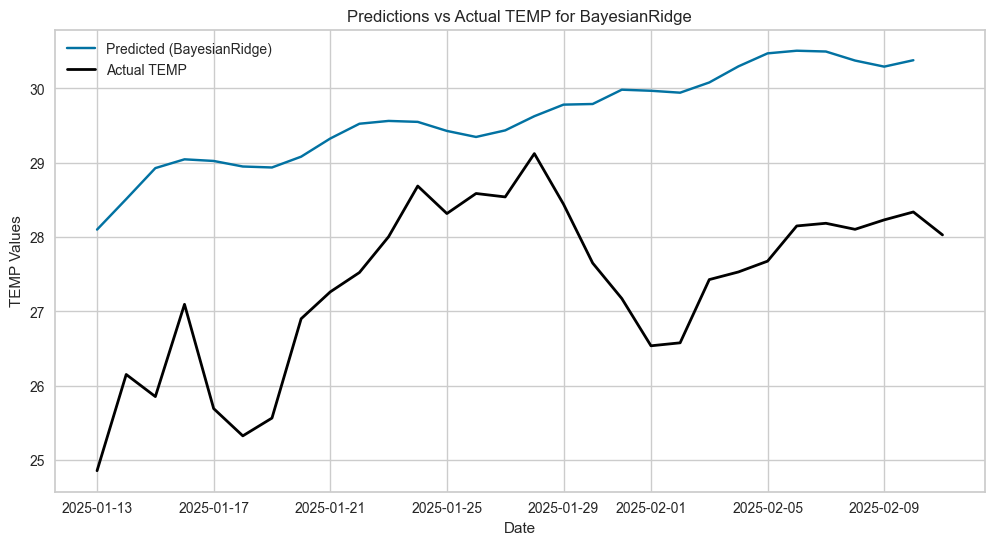

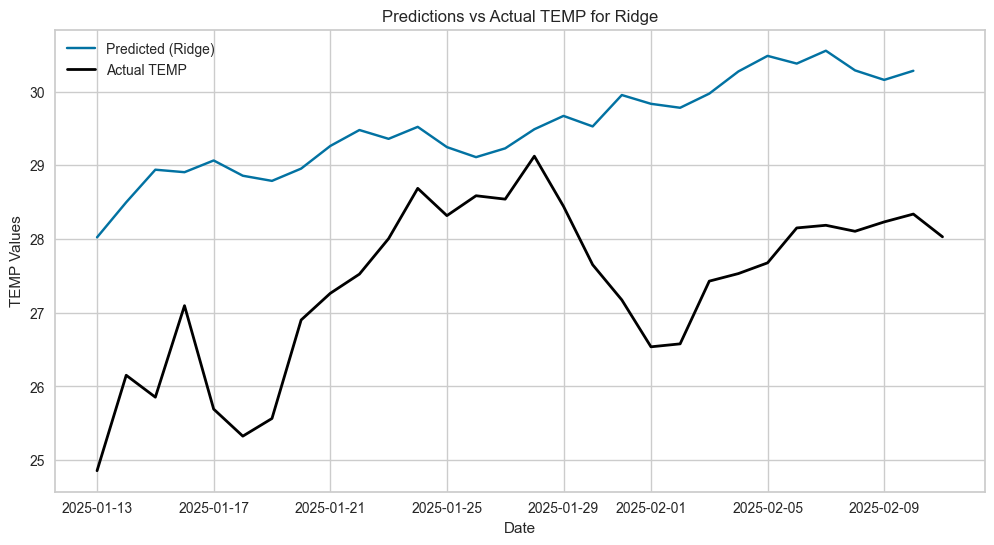

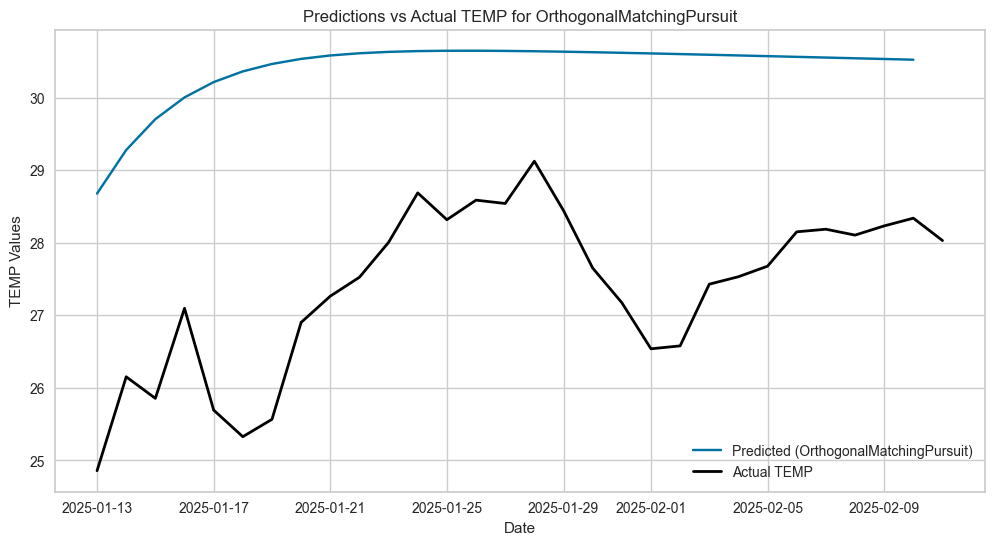

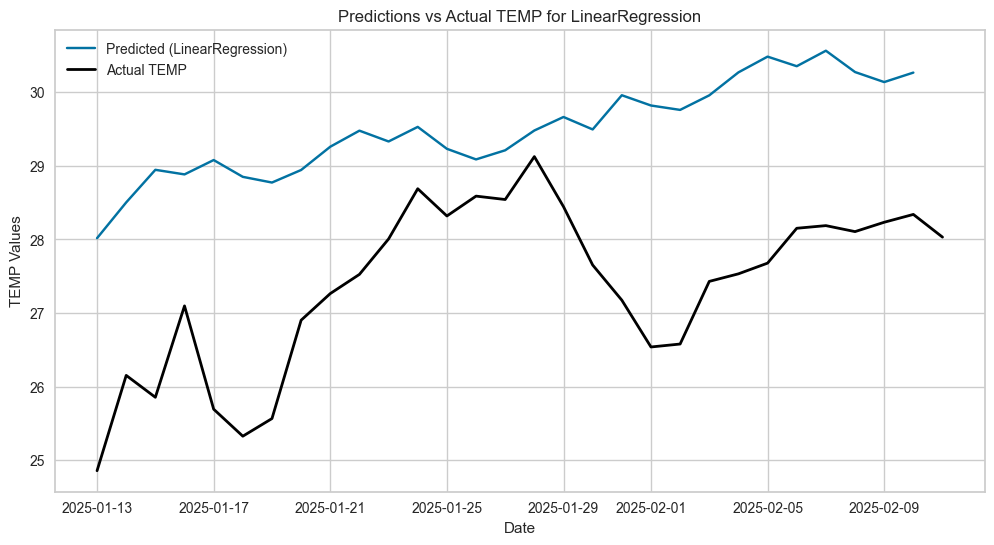

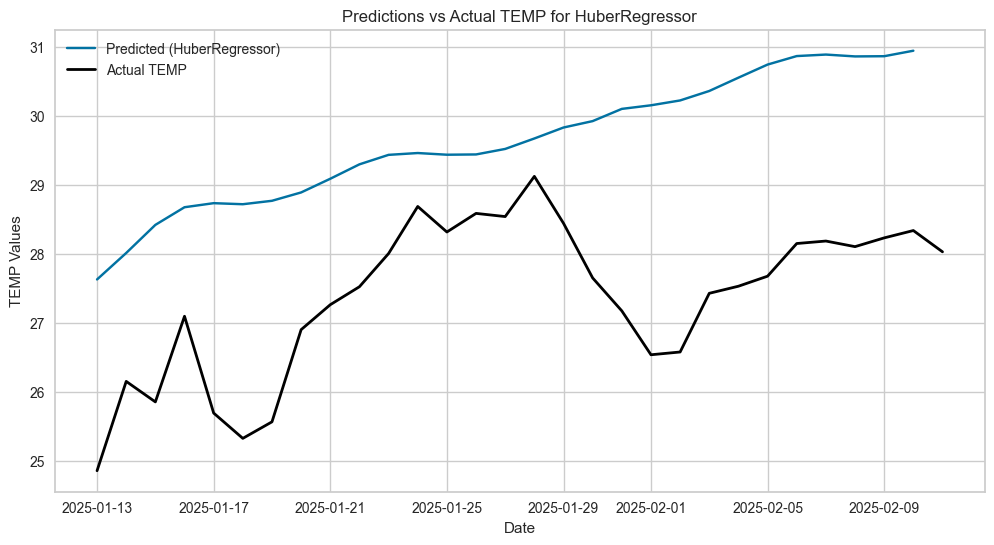

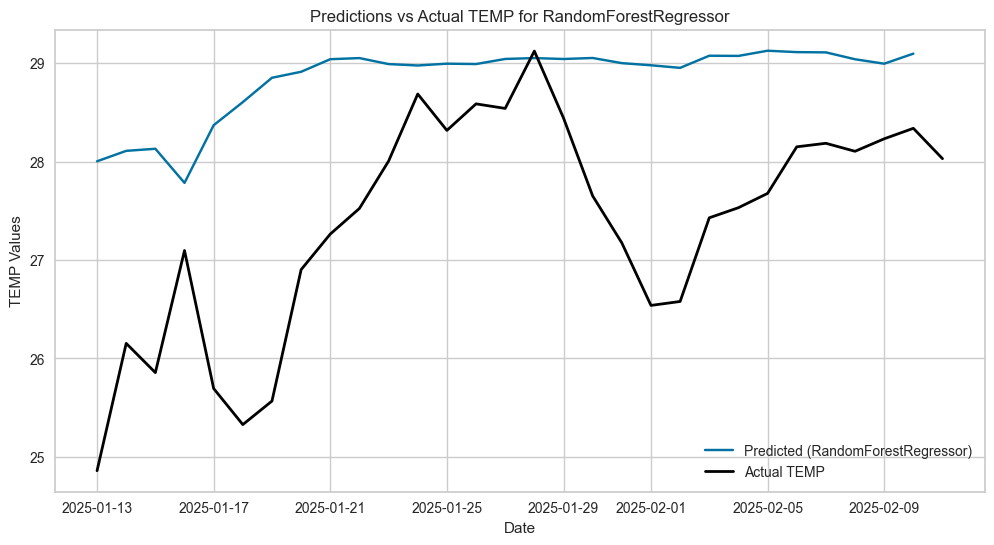

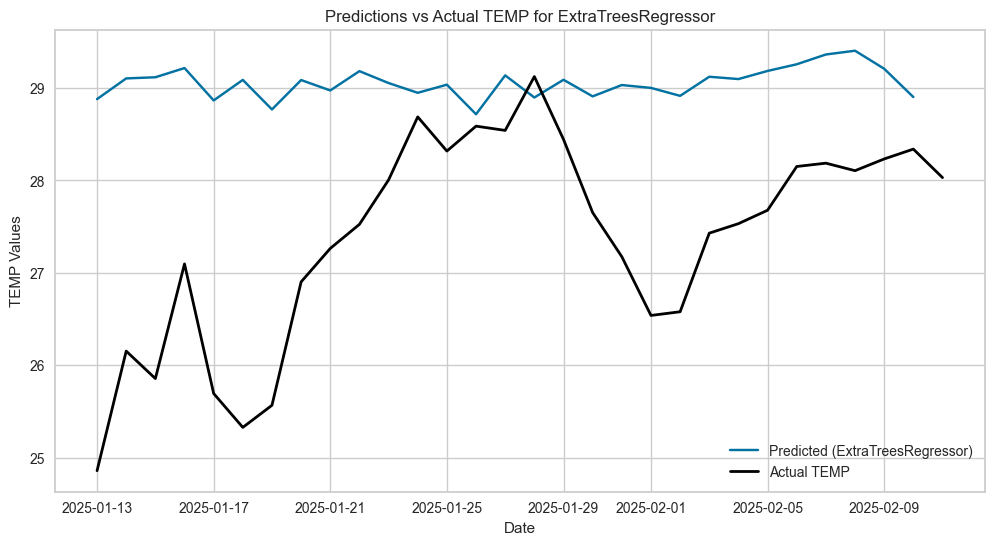

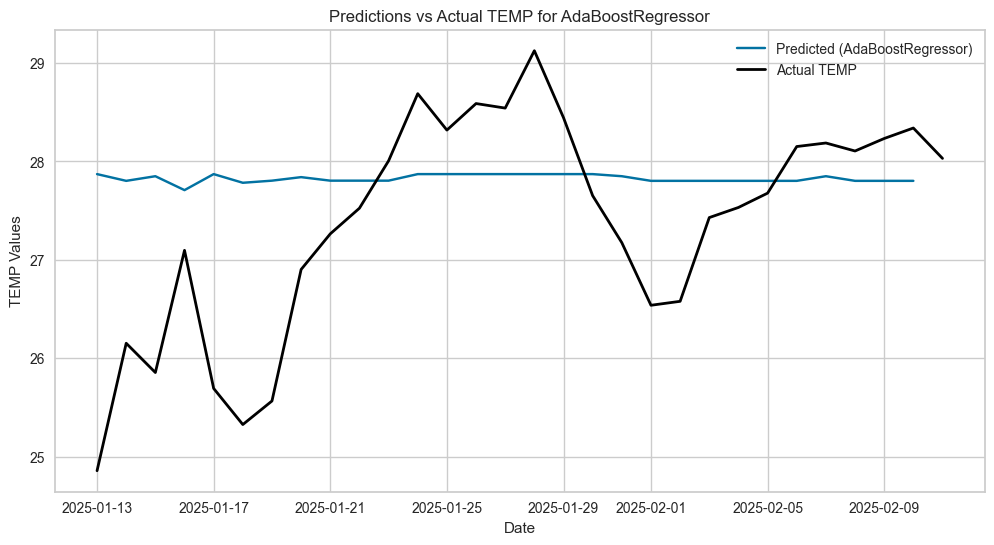

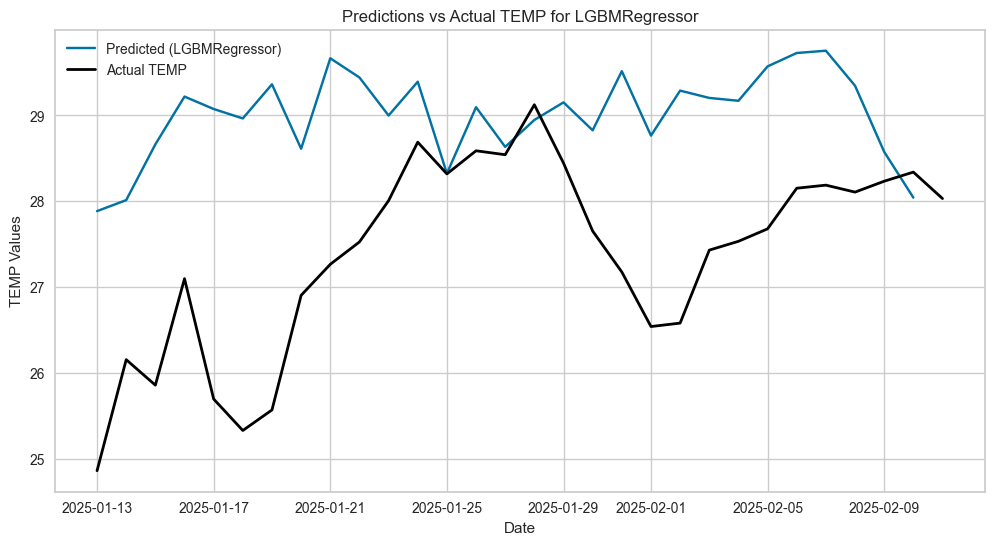

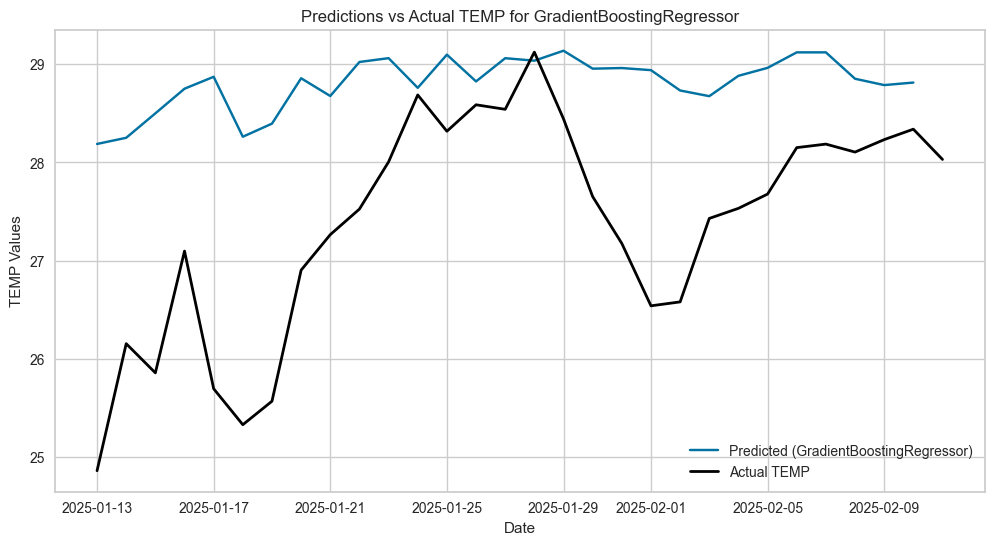

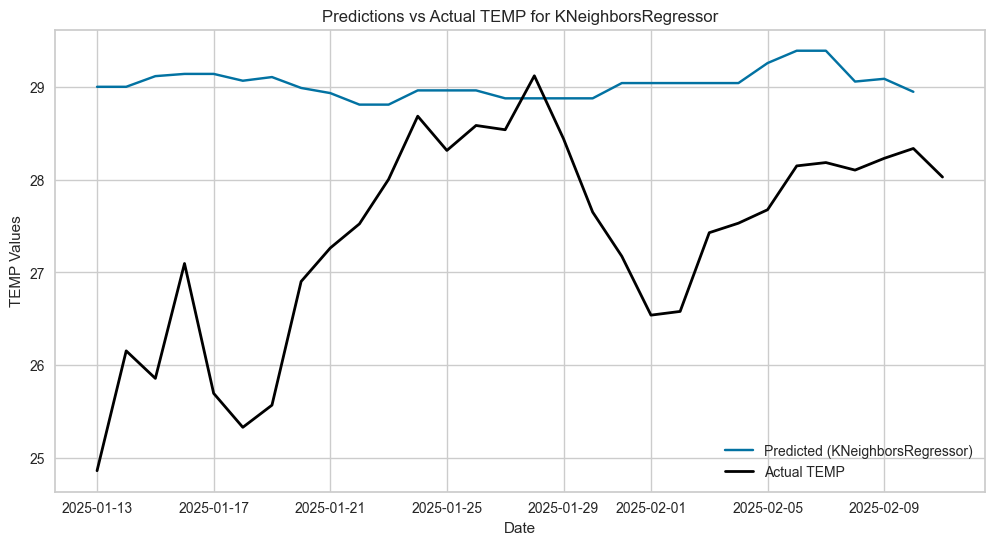

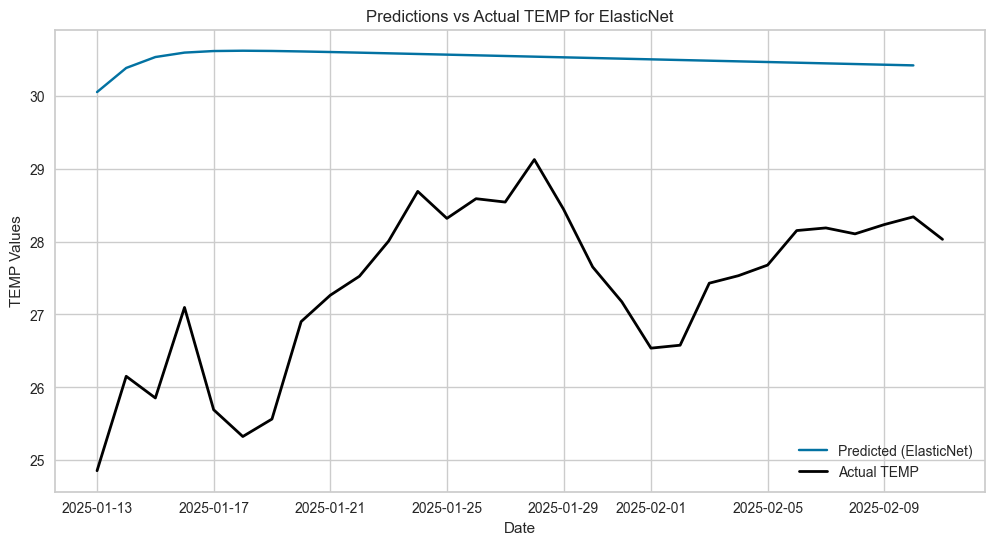

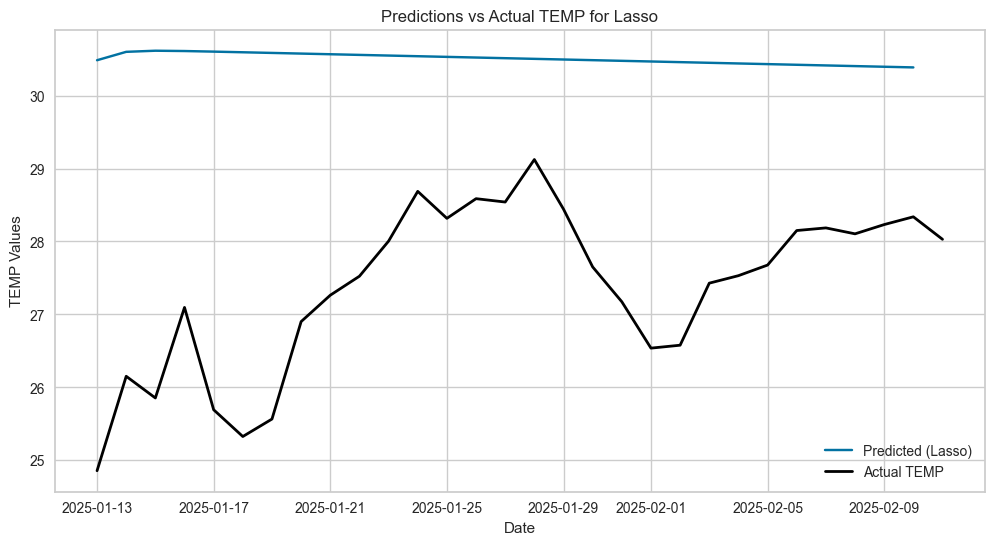

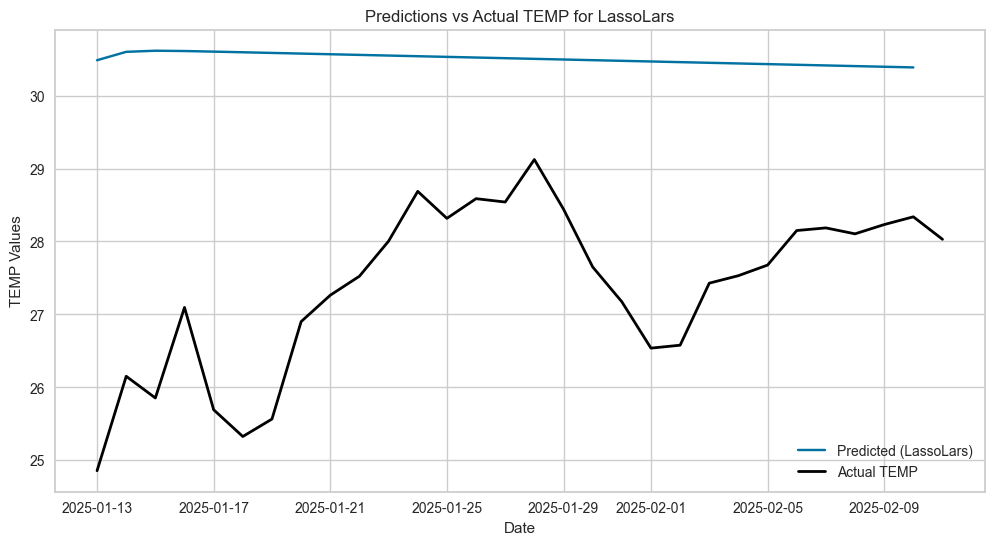

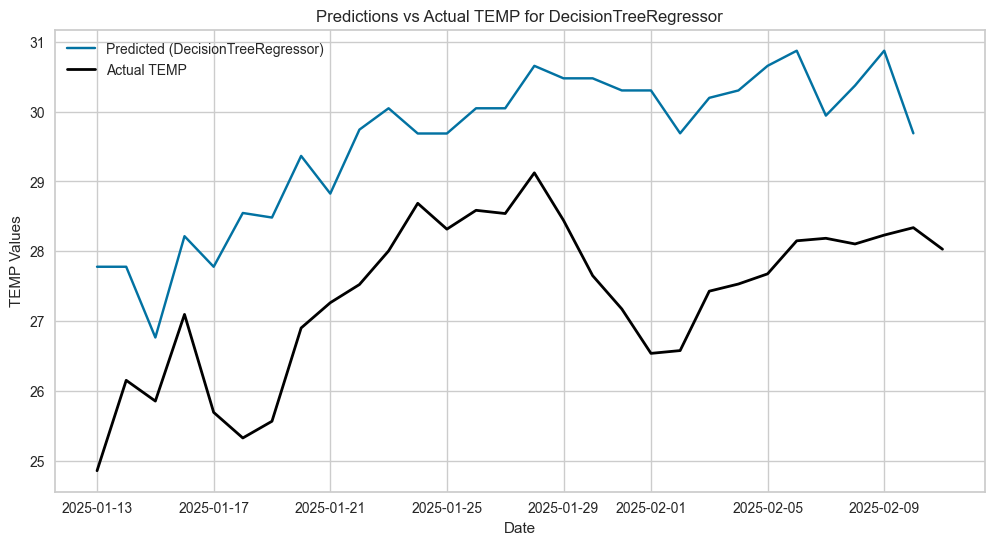

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'temperature'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['temperature'], label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

In [43]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'temperature'][:'2025-2-10']  # ค่าจริง
    y_pred = result['prediction_label'].shift(-1)  # ค่าพยากรณ์

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: BayesianRidge
R² Score: -3.6971
Mean Absolute Error (MAE): 2.2490
Root Mean Squared Error (RMSE): 2.4088
Mean Absolute Percentage Error (MAPE): 8.34%
Accuracy: 91.66%
--------------------------------------------------

📊 Model Performance Metrics:
Model: Ridge
R² Score: -3.3928
Mean Absolute Error (MAE): 2.1499
Root Mean Squared Error (RMSE): 2.3295
Mean Absolute Percentage Error (MAPE): 7.98%
Accuracy: 92.02%
--------------------------------------------------

📊 Model Performance Metrics:
Model: OrthogonalMatchingPursuit
R² Score: -7.1376
Mean Absolute Error (MAE): 3.0441
Root Mean Squared Error (RMSE): 3.1706
Mean Absolute Percentage Error (MAPE): 11.27%
Accuracy: 88.73%
--------------------------------------------------

📊 Model Performance Metrics:
Model: LinearRegression
R² Score: -3.3580
Mean Absolute Error (MAE): 2.1384
Root Mean Squared Error (RMSE): 2.3203
Mean Absolute Percentage Error (MAPE): 7.94%
Accuracy: 92.06%
-----------------------

# Predict and plot model blend +

In [44]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from itertools import combinations

# # ----- Blending Models -----
# best_list = list(best)
# model_names = {model.__class__.__name__: model for model in best_list}
# mape_results = {}
# blended_models = {}

# loop = 1
# for model1_name, model2_name in combinations(model_names.keys(), 2):
#     print(f"{loop} --> Blending: {model1_name} + {model2_name}")

#     blended_model = exp1.blend_models(
#         [model_names[model1_name], model_names[model2_name]], verbose=False
#     )
    
#     result = exp1.pull()
#     if "MAPE" in result.columns and "Mean" in result.index:
#         mape_value = result.loc["Mean", "MAPE"]
#     elif "R2" in result.columns and "Mean" in result.index:
#         mape_value = result.loc["Mean", "R2"]
#     else:
#         print(f"❌ ไม่มีค่าที่ต้องการสำหรับ {model1_name} + {model2_name}")
#         continue

#     mape_results[f"{model1_name}, {model2_name}"] = mape_value
#     blended_models[f"{model1_name}, {model2_name}"] = blended_model

#     print("-" * 60)
#     loop += 1

# # ----- Forecasting using Blended Models -----
# x = data_filtered.copy()
# x.index = pd.to_datetime(x.index).normalize()

# result_dict = {}
# start_date = "2025-01-13"
# end_date = "2025-02-11"

# for model_name, model in blended_models.items():
#     print(f"Processing blended model: {model_name}")

#     data_compare = x.loc[:'2025-01-12'].copy()
#     result = pd.DataFrame()

#     for date in pd.date_range(start=start_date, end=end_date, freq="D"):
#         date = pd.to_datetime(date).normalize()
#         if date not in x.index:
#             print(f"⚠️ Warning: Date {date} not found in x index.")
#             continue

#         test_1 = x.loc[[date]].copy()
#         data_compare = pd.concat([data_compare, test_1], axis=0)

#         for i in range(1, lag_size + 1):
#             test_1[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

#         test_1 = test_1.dropna()
#         predict_test_1 = exp1.predict_model(model, data=test_1)

#         predict_test_1.index = [date]
#         data_compare.loc[date, 'temperature'] = predict_test_1['prediction_label'].values[0]
#         result = pd.concat([result, predict_test_1], axis=0)

#     result_dict[model_name] = result

# # ----- Plotting Graphs -----
# real_data = x.loc[start_date:end_date]

# for model_name, result in result_dict.items():
#     plt.figure(figsize=(12, 6))
    
#     result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
#     result_plot.columns = ['Predictions', 'Actual TEMP']

#     plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
#     plt.plot(real_data.index, real_data['temperature'], label="Actual TEMP", color="black", linewidth=2)
    
#     plt.title(f'Predictions vs Actual TEMP for {model_name}')
#     plt.xlabel('Date')
#     plt.ylabel('TEMP Values')
#     plt.legend()

#     plt.show()


In [45]:
# for model_name, result in result_dict.items():
#     plt.figure(figsize=(12, 6))
    
#     result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
#     result_plot.columns = ['Predictions', 'Actual TEMP']

#     plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
#     plt.plot(real_data.index, real_data['temperature'], label="Actual TEMP", color="black", linewidth=2)
    
#     plt.title(f'Predictions vs Actual TEMP for {model_name}')
#     plt.xlabel('Date')
#     plt.ylabel('TEMP Values')
#     plt.legend()

#     plt.show()

In [46]:
# # --------------------------------------------
# # คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# # --------------------------------------------
# for model_name, result in result_dict.items():
#     y_true = x.loc[start_date:end_date, 'temperature'][:'2025-2-10']  # ค่าจริง
#     y_pred = result['prediction_label'].shift(-1)  # ค่าพยากรณ์

#     # ลบ NaN ที่เกิดจากการ shift
#     valid_idx = y_pred.dropna().index
#     y_true = y_true.loc[valid_idx]
#     y_pred = y_pred.loc[valid_idx]

#     r2 = r2_score(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
#     accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

#     # แสดงค่า Metrics ของโมเดลนี้
#     print("\n📊 Model Performance Metrics:")
#     print(f"Model: {model_name}")
#     print(f"R² Score: {r2:.4f}")
#     print(f"Mean Absolute Error (MAE): {mae:.4f}")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
#     print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
#     print(f"Accuracy: {accuracy:.2f}%")
#     print("-" * 50)